# ARABIC IMAGE CAPTIONING (AIC)
Image captioning refers to the ability of automatically generating a syntactically plausible and semantically meaningful sentence that describes the content of an image. Enabling machines to describe the visual world would result in many advantages, such as improved information retrieval, early childhood education, for visually impaired persons, for social media, and so on. It necessitates skills from the fields of Computer Vision (CV) and Natural Language Processing (NLP).

<img src="images/image_captioning_example.png" alt="image_captioning_example" width="550"/>

Tremendous achievements have been accomplished recently in English Image Captioning, thanks to deep neural networks. Inspired by recent advances in neural machine translation, the sequence-to-sequence encoder-decoder approach was adopted in here, where CNN encoder is utilized to extract image features (image embeddings) and RNN decoder decodes the encoded image features into words.

<img src="images/seq2seq-image-captioning-arabic.png" alt="seq2seq-image-captioning-arabic" width="750"/>

In [ ]:
# run this first if you want to ignore GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from resources.bleu import Bleu
from tqdm import tqdm_notebook, tnrange
import keras
from keras_tqdm import TQDMNotebookCallback
print(keras.__version__)
# for arabic text with matplotlib
from bidi import algorithm as bidialg
import arabic_reshaper

**NOTE:** If a module is not installed (e.g., tqdm), you can install it here in a new cell using the **pip** command preceded by exclamation mark (!) as following:

In [ ]:
!pip3 install tqdm

### Define variables
Here, we define some constant variables that we will use later. Variables include the path of the dataset (images & captions) and the path of other important resources such as the pre-trained VGG16 weights and images embeddings (the output of VGG16 (without the last layer) when fed with Flickr8K dataset).

In [2]:
vgg16_weights_path = 'resources/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
images_directory = 'data/Flicker8k_Dataset/'
captions_path = 'data/Flickr8k_text/Flickr8k.token.txt'
arabic_captions_path = 'data/Flickr8k_text/Flickr8k.arabic.full.txt'
train_path = 'data/Flickr8k_text/Flickr_8k.trainImages.txt'
dev_path = 'data/Flickr8k_text/Flickr_8k.devImages.txt'
images_features_path = 'resources/Flickr8K_features.pkl'
image_size = (224, 224) # as recommended by vgg16

images_path = []
images_names = []
captions = {} # dictionary where image name (witout extension) is key and list of 3 captions is value
captions_file_text = '' # content of the file that contains images names & their captions
vocabulary = [] # list of all unique words in captions

### Transfer Learning
To extract images embeddings using the encoder CNN, we will use VGG16, one of the state-of-the-art models for object detection. This is known as transfer learning, which refers to the situation where what has been learned in one setting (task) is exploited to learn other setting (task). It improve model generalization and fasten training.

We will load the VGG16 model from Keras, load the pre-trianed weights (can be downloaded from [this link](http://www.robots.ox.ac.uk/~vgg/research/very_deep/)), predict on (extarct feature from) Flickr8K images, and finally save extarcted images embeddings to pickle file. Later, we use the extarcted images embeddings (from the pickle file) as input to our model without the need to load VGG16 again. This trick will save us much time, but it has one disadvantage! Fine tuning (re training) the VGG16, which may improve performance, is now not possible!

In [10]:
def load_vgg16(weights_path, print_model_summary=False):
    """load the pre-trained vgg16 model"""
    #load vgg16 model with locally saved weights
    model = keras.applications.vgg16.VGG16(include_top=True, weights=weights_path)
    #remove last layer (fully connected of 1000 neurons) since we are not classifying
    model.layers.pop()
    model = keras.models.Model(inputs=model.inputs, outputs=model.layers[-1].output)
    if print_model_summary: model.summary()
    return model
    

def extract_images_features(img_directory, save_features_to):
    """extract images features using pre-trained vgg16 and save them in a pickle file"""
    features = dict() #to store features from each photo
    #load pre-trained vgg16 model
    pretrained_vgg16 = load_vgg16(vgg16_weights_path, False)
    #get images names
    img_names = os.listdir(img_directory)
    for i in tnrange(len(img_names)):
        #full image path
        img_path = os.path.join(img_directory, img_names[i])
        #load image form file
        img = keras.preprocessing.image.load_img(img_path, target_size=image_size)
        #convert image into numpy array
        img = keras.preprocessing.image.img_to_array(img)
        #reshape image for the model
        img = img.reshape((1,) + img.shape)
        #preprocess image for vgg16
        img = keras.applications.vgg16.preprocess_input(img)
        #get image features
        pred = pretrained_vgg16.predict(img, verbose=0)
        img_name = img_names[i].split('.')[0]
        #store image features
        features[img_name] = pred
    #save image features to pickle file
    pickle.dump(features, open(save_features_to,'wb'))
    print('images features saved to',save_features_to)

extract_images_features(images_directory, images_features_path)


images features saved to AIC/resources/Flickr8K_features.pkl


### Read & visualize dataset

In [31]:
def load_file_text(file_path):
    """reads and returns text in captions file"""
    file = open(file_path, 'r', encoding='utf-8')
    all_text = file.read()
    file.close()
    return all_text

def get_captions(file_text):
    """given file content, returns images names and their captions as dictionary"""
    cpts = {}
    #loop through lines
    for line in file_text.split('\n'): # each line contains image name & its caption separated by tab
        #split by tabs
        img_cpt = line.split('\t')
        if len(img_cpt) < 2: continue
        img, cpt = img_cpt
        #remove image extension & index (remove everything befor the dot)
        img_name = img.split('.')[0]
        #add to dictionary
        if img_name not in cpts:
            cpts[img_name] = [cpt]
        else:
            cpts[img_name].append(cpt)
    return cpts

captions_file_text = load_file_text(arabic_captions_path)
captions = get_captions(captions_file_text)
print('Captions #:', len(captions))
print('Caption example:', list(captions.values())[0])

Captions #: 8091
Caption example: ['طفلة صغيرة تتسلق إلى مسرح خشبي', 'طفلة صغيرة تتسلق الدرج إلى منزلها', 'فتاة صغيرة في ثوب وردي تذهب إلى المقصورة الخشبية']


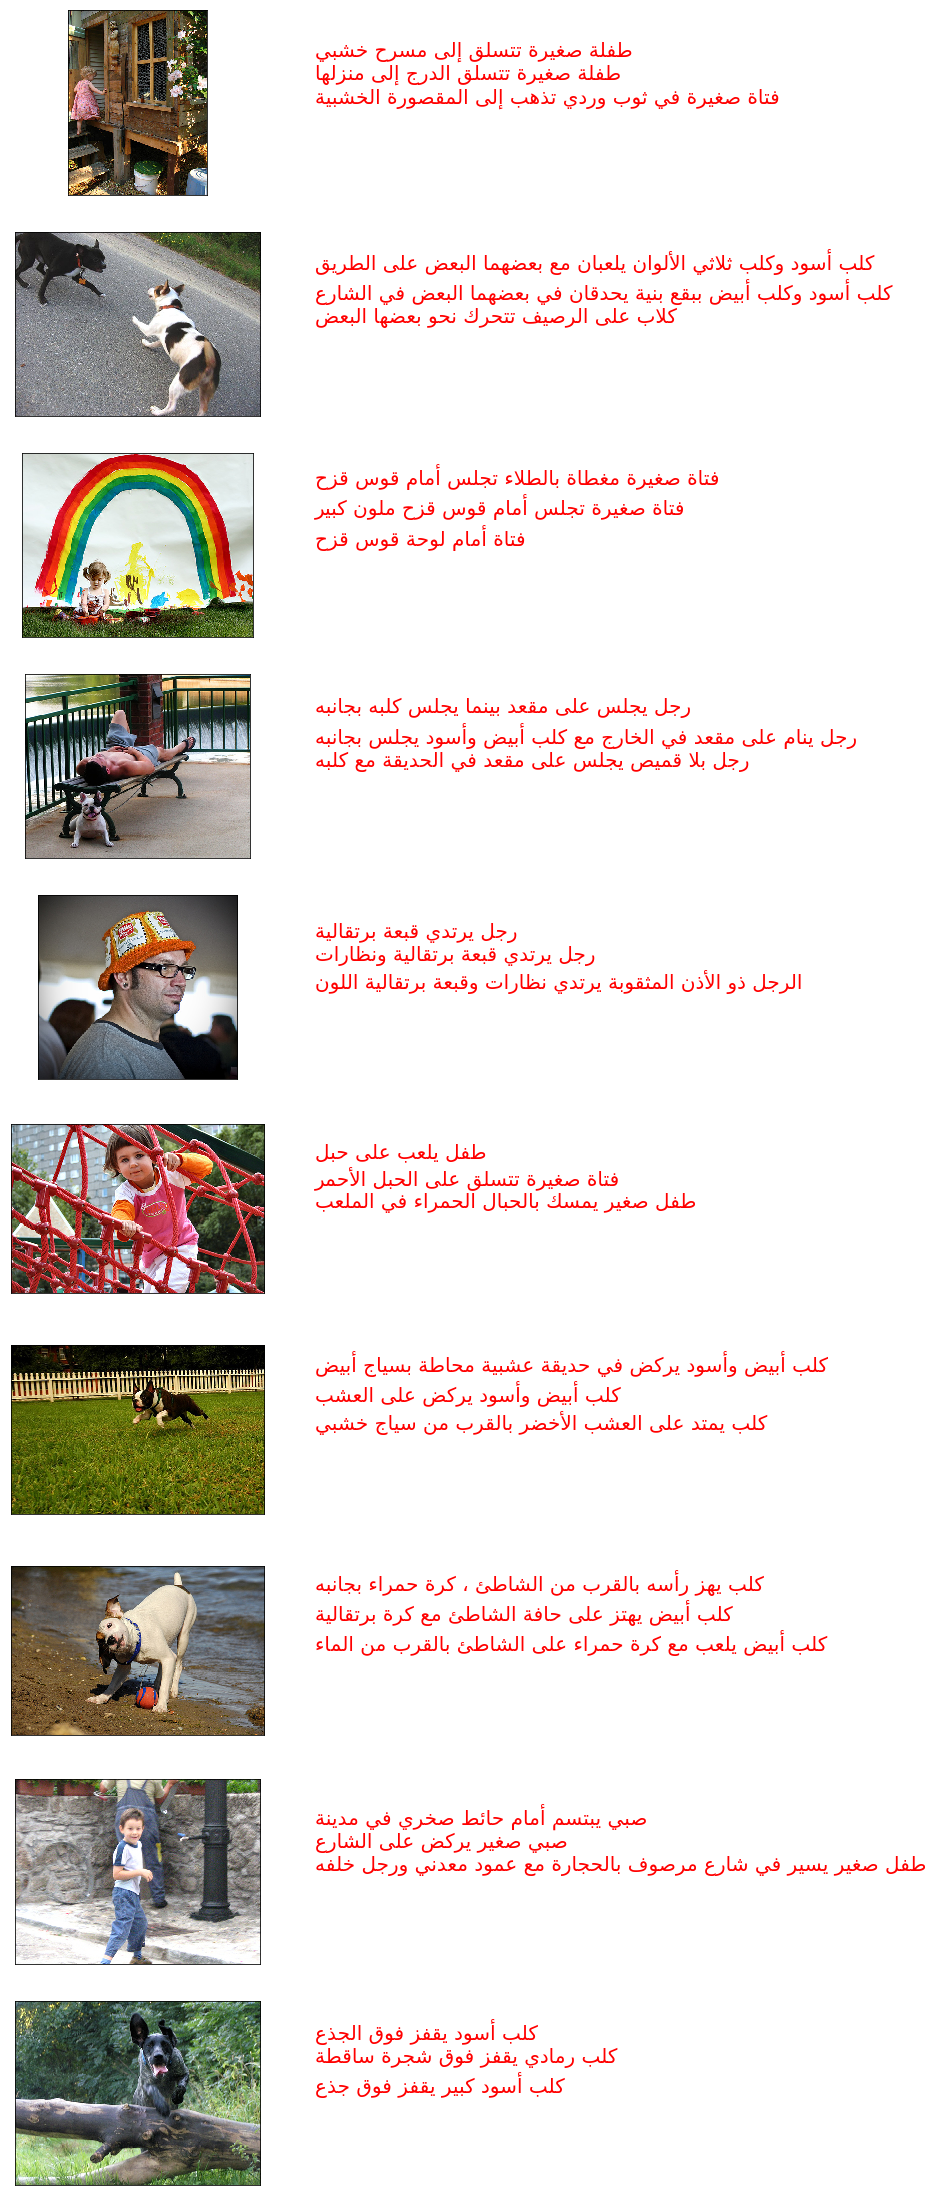

In [32]:
def visualize_images_with_captions(cpts):
    """plot images with their captions"""
    n_pics = len(cpts)
    i = 0
    fig = plt.figure(figsize=(10,n_pics*4))
    #for i,line in enumerate(lines[:n_pics]):
    for img,cpt in cpts.items():
        img_file = img + '.jpg'
        img = keras.preprocessing.image.load_img(images_directory + img_file)
        cpt_ = '\n'.join(cpt)
        caption = arabic_reshaper.reshape(cpt_)
        caption = bidialg.get_display(caption)
        ax = fig.add_subplot(n_pics,2,2*i+1,xticks=[],yticks=[])
        ax.imshow(img)
        ax = fig.add_subplot(n_pics,2,2*i+2)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.5,caption,fontsize=20,fontdict={'color':  'red','weight': 'normal','size': 14}) #'family': 'serif',
        i += 1

subset = {k:captions[k] for k in list(captions.keys())[:10]}
visualize_images_with_captions(subset)

### Preprocessing & cleaning captions

In [25]:
text = 'صبي وبنت بيت وهو'
re.sub(r'\sو(\w+)', r' و \1', text)

'صبي و بنت بيت و هو'

In [35]:
text = 'الي البيت الكبير'
re.sub(r'\bال(\w\w+)', r'\1', text)  # remove al ta3reef

'الي بيت كبير'

In [16]:
re.search('\w+', ' 456')

<_sre.SRE_Match object; span=(1, 4), match='456'>

In [5]:
from string import punctuation

def preprocess_captions(cpts):
    """ clean captions to reduce vocabulary size we need to work with:
        - lowercase
        - remove punctuations
        - remove one-character words
        - remove words with numbers
    """
    for img, cpt in cpts.items():
        cpts_ = []
        for c in cpt:
            c = c.lower() #lower case all caption
            c = ''.join([char for char in c if char not in punctuation]) #remove punctuations
            c = ' '.join([w for w in c.split() if len(w)>1 and w.isalpha()]) #remove one-character & numeric words
            cpts_.append(c)
        cpts[img] = cpts_
k = '299178969_5ca1de8e40' #2660480624_45f88b3022
print('before >>', captions[k])
preprocess_captions(captions)
print('captions preprocessed :)')
print('after >>', captions[k])

before >> ['صبي ,يرتدي اللون الأزرق ,  على الأشجار', 'صبي صغير ذو شعر أشقر يبتسم بينما يستلقي على فرع شجرة', 'صبي أشقر يرتدي معطف جينز  ، يجلس على  شجرة']
captions preprocessed :)
after >> ['صبي يرتدي اللون الأزرق على الأشجار', 'صبي صغير ذو شعر أشقر يبتسم بينما يستلقي على فرع شجرة', 'صبي أشقر يرتدي معطف جينز يجلس على شجرة']


In [33]:
from resources.arabic_preprocessing import Arabic_preprocessing

def preprocess_captions(cpts):
    """ clean captions to get rid of useless textual info & reduce vocabulary size. Preprocessing includes:
        - remove punctuations & diacritics
        - normalize (or standarize) Hamza & Ha2
        - remove repeating characters
        - remove english characters
        - remove one-character words
    """
    process_arab = Arabic_preprocessing()
    for img, cpt in cpts.items():
        processed_captions = [process_arab.preprocess_arabic_text(c) for c in cpt]
        cpts[img] = processed_captions

k = '299178969_5ca1de8e40' #2660480624_45f88b3022
print('before >>', captions[k])
preprocess_captions(captions)
print('captions preprocessed :)')
print('after >>', captions[k])

before >> ['صبي ,يرتدي اللون الأزرق ,  على الأشجار', 'صبي صغير ذو شعر أشقر يبتسم بينما يستلقي على فرع شجرة', 'صبي أشقر يرتدي معطف جينز  ، يجلس على  شجرة']
captions preprocessed :)
after >> ['صبي يرتدي لون ازرق علي اشجار', 'صبي صغير ذو شعر اشقر يبتسم بينما يستلقي علي فرع شجره', 'صبي اشقر يرتدي معطف جينز يجلس علي شجره']


In [34]:
i = 0
for k,v in captions.items():
    print(v)
    i += 1
    if i == 10: break

['طفله صغيره تتسلق الي مسرح خشبي', 'طفله صغيره تتسلق درج الي منزلها', 'فتاه صغيره في ثوب و ردي تذهب الي مقصوره خشبيه']
['كلب اسود و كلب ثلاثي الوان يلعبان مع بعضهما بعض علي طريق', 'كلب اسود و كلب ابيض ببقع بنيه يحدقان في بعضهما بعض في شارع', 'كلاب علي رصيف تتحرك نحو بعضها بعض']
['فتاه صغيره مغطاه بالطلاء تجلس امام قوس قزح', 'فتاه صغيره تجلس امام قوس قزح ملون كبير', 'فتاه امام لوحه قوس قزح']
['رجل يجلس علي مقعد بينما يجلس كلبه بجانبه', 'رجل ينام علي مقعد في خارج مع كلب ابيض و اسود يجلس بجانبه', 'رجل بلا قميص يجلس علي مقعد في حديقه مع كلبه']
['رجل يرتدي قبعه برتقاليه', 'رجل يرتدي قبعه برتقاليه و نظارات', 'رجل ذو اذن مثقوبه يرتدي نظارات و قبعه برتقاليه لون']
['طفل يلعب علي حبل', 'فتاه صغيره تتسلق علي حبل احمر', 'طفل صغير يمسك بالحبال حمراء في ملعب']
['كلب ابيض و اسود يركض في حديقه عشبيه محاطه بسياج ابيض', 'كلب ابيض و اسود يركض علي عشب', 'كلب يمتد علي عشب اخضر بالقرب من سياج خشبي']
['كلب يهز راسه بالقرب من شاطئ كره حمراء بجانبه', 'كلب ابيض يهتز علي حافه شاطئ مع كره برتقاليه', 'كلب ابيض يلع

In [35]:
for k,v in captions.items():
    for cpt in v:
        a = [w for w in cpt.split() if len(w)==1 and w!='و']
        if len(a)>0: print(cpt)

In [36]:
%%time
def get_vocabulary(cpts):
    """retruns a list of all unique words in captions"""
    captions_flattened = [cpt for image_captions in cpts.values() for cpt in image_captions]
    all_captions = ' '.join(captions_flattened)
    v = set(all_captions.split())
    return sorted(list(v))

vocabulary = get_vocabulary(captions)
print('Vocabulary size (number of unique words):', len(vocabulary))

Vocabulary size (number of unique words): 8435
Wall time: 33.9 ms


In [37]:
%%time
def get_frequent_vocabulary(cpts, frequency=5):
    """retruns a list of all unique words that appeared more than `frequency` times"""
    captions_flattened = [cpt for image_captions in cpts.values() for cpt in image_captions]
    all_captions = ' '.join(captions_flattened)
    frequent_vocabulary = []
    for i,v in enumerate(vocabulary):
        if all_captions.count(v) >= frequency: frequent_vocabulary.append(v)
    return frequent_vocabulary

frequent_vocabulary = get_frequent_vocabulary(captions, 3)
print('Frequent vocabulary size (number of unique words):', len(frequent_vocabulary))

Frequent vocabulary size (number of unique words): 4262
Wall time: 5.74 s


In [38]:
%%time

def vocab_counts(cpts, vocab):
    captions_flattened = [cpt for image_captions in cpts.values() for cpt in image_captions]
    all_captions = ' '.join(captions_flattened)
    vocab_dict = {}
    for w in vocab:
        vocab_dict[w] = all_captions.count(w)
    return vocab_dict

def get_word_given_count(vocab_counts, count):
    for k,v in vocab_counts.items():
        if v == count:
            return k

vocabulary_counts = vocab_counts(captions, frequent_vocabulary)
max_word_count = max(list(vocabulary_counts.values()))
min_word_count = min(list(vocabulary_counts.values()))
max_word = get_word_given_count(vocabulary_counts, max_word_count)
min_word = get_word_given_count(vocabulary_counts, min_word_count)
print('the word that appeared the most is:', max_word, ' It appeared', max_word_count, 'times')
print('the word that appeared the least is:', min_word, ' It appeared', min_word_count, 'times')

the word that appeared the most is: و  It appeared 28166 times
the word that appeared the least is: ابتسامات  It appeared 3 times
Wall time: 2.94 s


In [39]:
def add_start_end_to_captions(cpts):
    """precede each caption with <START> and end each caption with <END>"""
    start, end = '<START>', '<END>'
    #start, end = 'start', 'end'
    for k, v in cpts.items():
        image_captions = [start + ' ' + cpt + ' ' + end for cpt in v]
        cpts[k] = image_captions

add_start_end_to_captions(captions)
print(captions[k])

['<START> رجل يرتدي قميصا و رديا يتسلق و جها صخريا <END>', '<START> رجل يتسلق صخور في هواء <END>', '<START> متسلق صخره في قميص احمر <END>']


In [40]:
# load image embeddings extracted from VGG16 earlier
features = pickle.load(open(images_features_path, 'rb'))

XX, yy = [], []
for k,v in captions.items():
    if k in features:
        #get input (image features)
        XX.append(features[k])
        #get output (image caption)
        yy.append(v)

In [41]:
X, y = [],[]
for image_features, image_captions in zip(XX,yy):
    for image_caption in image_captions:
        X.append(image_features)
        y.append(image_caption)
print(len(X),len(y))

24273 24273


In [42]:
assert len(X)==len(y) , 'something is worng!'
assert len(X)==len(captions)*3 , 'something is worng!'

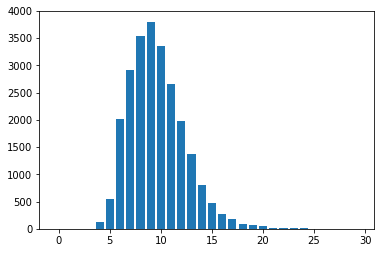

In [43]:
captions_lengths = [0] * 30
for yy in y:
    l = len(yy.split())
    if l < len(captions_lengths):
        captions_lengths[l] += 1
plt.bar(list(range(30)), captions_lengths)
plt.show()

In [44]:
max_len = 20

### Tokenize text: convert from text to numbers

In [45]:
#max_len = max([len(cpt.split()) for cpt in y])
num_words = len(frequent_vocabulary) + 1
tokenizer = keras.preprocessing.text.Tokenizer(num_words=num_words, oov_token='<UNK>', lower=False, filters='') # num_words=num_words, 
tokenizer.fit_on_texts(y)
tokenizer.word_index['<PAD>'] = 0
##### fix for keeping only most common `num_words`
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= num_words} # <= because tokenizer is 1 indexed
#####
word2index = tokenizer.word_index
index2word = {v:k for k,v in word2index.items()}
#tokenize captions
y_tok = tokenizer.texts_to_sequences(y)

In [47]:
print(max_len)
print(len(frequent_vocabulary), len(word2index))

20
4262 4264


In [48]:
print('tokenized caption:', y_tok[0])
print('untokenized caption:', tokenizer.sequences_to_texts([y_tok[0]])[0])

tokenized caption: [2, 207, 33, 325, 25, 322, 227, 3]
untokenized caption: <START> طفله صغيره تتسلق الي مسرح خشبي <END>


In [49]:
# split
test_size = 800*3
X_train = X[:-test_size]
y_train = y_tok[:-test_size]
X_test = X[-test_size:]
y_test = y_tok[-test_size:]

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

21873 21873
2400 2400


In [50]:
%%time

def prepare_data_for_model(images_features, cpts, max_len, vocab_size):
    input_image, input_text, output_text = [], [], []
    for img,cpt in zip(images_features,cpts):
        for i in range(1, len(cpt)): #for i in range(1, min(max_len,len(cpt))):
                # split into input and output pair
                in_text, out_text = cpt[:i], cpt[i]
                # pad input sequence
                in_text = keras.preprocessing.sequence.pad_sequences([in_text], maxlen=max_len, padding='post')[0]
                # encode output sequence
                out_text = keras.utils.to_categorical([out_text], num_classes=vocab_size)[0]
                # store
                input_image.append(img)
                input_text.append(in_text)
                output_text.append(out_text)
    return np.array(input_image, dtype=np.int16), np.array(input_text, dtype=np.int16), np.array(output_text, dtype=np.int16)

X_train_image, X_train_text, y_train_text = prepare_data_for_model(X_train, y_train, max_len, len(word2index))
X_train_image = np.squeeze(X_train_image)
print(X_train_image.shape, X_train_text.shape, y_train_text.shape)

X_test_image, X_test_text, y_test_text = prepare_data_for_model(X_test, y_test, max_len, len(word2index))
X_test_image = np.squeeze(X_test_image)
print(X_test_image.shape, X_test_text.shape, y_test_text.shape)

(188115, 4096) (188115, 20) (188115, 4264)
(20814, 4096) (20814, 20) (20814, 4264)
Wall time: 43.3 s


### Building the model: seq2seq encoder-decoder (with GRU)

In [16]:
class My_Callback(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs):
        logs['BLEU-train'] = self.calculate_bleu(X_train, y_train)
        logs['BLEU-test'] = self.calculate_bleu(X_test, y_test)
        print('BLEU-train:',logs['BLEU-train'],' BLEU-test:',logs['BLEU-test'])
        
    def chop_start_end(self, cpt):
        return cpt.split()[1:-1]
    
    def calculate_bleu(self, X, y):
        bt = []
        for xx,yy in zip(X,y):
            pred = predict_caption(self.model, xx, tokenizer, max_len)
            pred = self.chop_start_end(pred)
            actual = tokenizer.sequences_to_texts([yy])[0]
            actual = self.chop_start_end(actual)
            #print('actual >>',actual)
            #print('pred >>',pred)
            b = sentence_bleu([actual], pred, weights=(1, 0, 0, 0))
            bt.append(b)
        return np.mean(bt)

In [51]:
class Bleu_Callback(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs):
        XX_test, yy_test = get_one_by_three(X_test, y_test)
        XX_test = np.squeeze(np.array(XX_test))
        yy_test_text = [tokenizer.sequences_to_texts(y_) for y_ in yy_test]
        generated_captions_test = generate_captions(self.model, XX_test)
        list_of_references = []
        for images_captions in yy_test_text:
            list_of_references.append([chop_start_end(cpt) for cpt in images_captions])
        hypotheses = [chop_start_end(cpt) for cpt in generated_captions_test]
        refs, hyps = {}, {}
        for i,(actual, pred) in enumerate(zip(list_of_references,hypotheses)):
            refs['id{}'.format(i)] = actual
            hyps['id{}'.format(i)] = [pred]
        b = Bleu(n=4)
        b1,b2,b3,b4 = b.compute_score(refs, hyps)[0]
        logs['b1'] = b1
        logs['b2'] = b2
        logs['b3'] = b3
        logs['b4'] = b4
        print('b1:',b1,'  b2',b2,'  b3',b3,'  b4',b4)

In [60]:
embeddings_dim = 256
input_image_dim = X_train_image.shape[1]

keras.backend.clear_session()

# image model
input_image = keras.layers.Input(shape=(input_image_dim,), name='input_image')
#input_image_dropout = keras.layers.Dropout(0.4)(input_image)
image_embeddings = keras.layers.Dense(embeddings_dim, activation='tanh', name='image_embeddings') (input_image)

# text model
# Set up the decoder, using `image_embeddings` as initial state.
decoder_inputs = keras.layers.Input(shape=(max_len,))
embeddings = keras.layers.Embedding(len(word2index), embeddings_dim, mask_zero=True)(decoder_inputs)
#embeddings_dropout = keras.layers.Dropout(0.3)(embeddings)
gru = keras.layers.GRU(embeddings_dim)(embeddings, initial_state=image_embeddings) # , return_sequences=True
#flat = keras.layers.Flatten()(gru)
dense = keras.layers.Dense(embeddings_dim, activation='relu')(gru)
#dense_dropout = keras.layers.Dropout(0.3)(dense)
decoder_outputs = keras.layers.Dense(len(word2index), activation='softmax')(dense)

seq2seq = keras.Model([input_image, decoder_inputs], decoder_outputs)
seq2seq.summary()

# prepare callback
#histories = My_Callback()

model_checkpoint_path = 'models/model.{epoch:02d}-{val_loss:.3f}--{b1:.3f}.hdf5'
checkpoint_callback = keras.callbacks.ModelCheckpoint(model_checkpoint_path, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
callbacks = [TQDMNotebookCallback(), Bleu_Callback(), checkpoint_callback] #[checkpoint_callback, TQDMNotebookCallback(), My_Callback()]

seq2seq.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy')

seq2seq.fit([X_train_image, X_train_text], y_train_text,
            validation_data=([X_test_image, X_test_text], y_test_text),
            batch_size=1024,
            epochs=10,
            verbose=2,
            callbacks=callbacks) # add My_Callback() to callbacks to calculate & display BLEU score after each epoch

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_image (InputLayer)        (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 256)      1091584     input_1[0][0]                    
__________________________________________________________________________________________________
image_embeddings (Dense)        (None, 256)          1048832     input_image[0][0]                
__________________________________________________________________________________________________
gru_1 (GRU

Epoch 1/10


 - 18s - loss: 5.3424 - val_loss: 4.5899
{'testlen': 8405, 'reflen': 5949, 'guess': [8405, 7605, 6805, 6005], 'correct': [1441, 234, 54, 19]}
ratio: 1.4128424945366593
b1: 0.1714455681141973   b2 0.0726309042327501   b3 0.03472184900345404   b4 0.019077096668491

Epoch 00001: saving model to models/model.01-4.590--0.171.hdf5


C:\Users\oae15\AppData\Local\Continuum\anaconda3\envs\coding4fun\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer gru_1 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'image_embeddings/Tanh:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10


 - 16s - loss: 4.1121 - val_loss: 4.0235
{'testlen': 10610, 'reflen': 6733, 'guess': [10610, 9810, 9010, 8210], 'correct': [1471, 272, 38, 5]}
ratio: 1.57582058517725
b1: 0.13864278982091058   b2 0.06200098551655317   b3 0.025309602848121032   b4 0.009968291043905515

Epoch 00002: saving model to models/model.02-4.024--0.139.hdf5
Epoch 3/10


 - 16s - loss: 3.6138 - val_loss: 3.8134
{'testlen': 7471, 'reflen': 6333, 'guess': [7471, 6671, 5871, 5071], 'correct': [1575, 326, 76, 25]}
ratio: 1.1796936680876078
b1: 0.21081515192073205   b2 0.10149957892515103   b3 0.05109087386924472   b4 0.02847535176688479

Epoch 00003: saving model to models/model.03-3.813--0.211.hdf5
Epoch 4/10


 - 17s - loss: 3.3293 - val_loss: 3.7156
{'testlen': 9072, 'reflen': 6537, 'guess': [9072, 8272, 7472, 6672], 'correct': [1629, 337, 53, 8]}
ratio: 1.3877925653967587
b1: 0.17956349206347227   b2 0.08553004665736864   b3 0.03729856654973829   b4 0.015793471222374973

Epoch 00004: saving model to models/model.04-3.716--0.180.hdf5
Epoch 5/10


 - 16s - loss: 3.1252 - val_loss: 3.6790
{'testlen': 8518, 'reflen': 6488, 'guess': [8518, 7718, 6918, 6118], 'correct': [1684, 380, 85, 20]}
ratio: 1.3128853267568876
b1: 0.19769899037330385   b2 0.09866011944254593   b3 0.04926901508962883   b4 0.025005499900098777

Epoch 00005: saving model to models/model.05-3.679--0.198.hdf5
Epoch 6/10


 - 17s - loss: 2.9632 - val_loss: 3.6727
{'testlen': 6733, 'reflen': 5867, 'guess': [6733, 5933, 5133, 4333], 'correct': [1684, 340, 72, 17]}
ratio: 1.1476052497015259
b1: 0.250111391653015   b2 0.11972063748696368   b3 0.05858230081005403   b4 0.029801620257105168

Epoch 00006: saving model to models/model.06-3.673--0.250.hdf5
Epoch 7/10


 - 16s - loss: 2.8219 - val_loss: 3.6800
{'testlen': 7141, 'reflen': 5980, 'guess': [7141, 6341, 5541, 4741], 'correct': [1749, 399, 90, 25]}
ratio: 1.1941471571904356
b1: 0.24492368015680646   b2 0.12414320674224447   b3 0.06302314805536229   b4 0.03389554200643623

Epoch 00007: saving model to models/model.07-3.680--0.245.hdf5
Epoch 8/10


 - 17s - loss: 2.6968 - val_loss: 3.7187
{'testlen': 7694, 'reflen': 6198, 'guess': [7694, 6894, 6094, 5294], 'correct': [1830, 428, 101, 28]}
ratio: 1.2413681832847303
b1: 0.23784767351179648   b2 0.12151662497573647   b3 0.06255040229226563   b4 0.033729981577907305

Epoch 00008: saving model to models/model.08-3.719--0.238.hdf5
Epoch 9/10


 - 16s - loss: 2.5825 - val_loss: 3.7410
{'testlen': 6083, 'reflen': 5822, 'guess': [6083, 5283, 4483, 3683], 'correct': [1813, 424, 79, 19]}
ratio: 1.0448299553416274
b1: 0.29804372842342625   b2 0.15466164204197366   b3 0.07497926784476674   b4 0.03840111786991306

Epoch 00009: saving model to models/model.09-3.741--0.298.hdf5
Epoch 10/10


 - 16s - loss: 2.4724 - val_loss: 3.7928
{'testlen': 5879, 'reflen': 5752, 'guess': [5879, 5079, 4279, 3479], 'correct': [1776, 434, 100, 33]}
ratio: 1.0220792767731184
b1: 0.30209219254970193   b2 0.16066656509708377   b3 0.08449601822501104   b4 0.04890936909022643

Epoch 00010: saving model to models/model.10-3.793--0.302.hdf5


### save trained model

In [19]:
#from keras.models import load_model
seq2seq.save('models/seq2seq_no_dropout_3.h5')  # creates a HDF5 file 'my_model.h5'

C:\Users\oae15\AppData\Local\Continuum\anaconda3\envs\coding4fun\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer gru_1 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'image_embeddings/Tanh:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


### Predict & Evaluate

In [24]:
def predict_caption(model, images_features, tokenizer, maxlen):
    in_txt = '<START>'
    for word in range(max_len):
        seq = tokenizer.texts_to_sequences([in_txt])[0]
        seq = keras.preprocessing.sequence.pad_sequences([seq], maxlen=maxlen)
        pred = model.predict([images_features, seq], verbose=0)
        pred = np.argmax(pred)
        new_word = index2word[pred]
        in_txt += ' ' + new_word
        if new_word == '<END>':
            #print('I saw END at index',word)
            break
    return in_txt

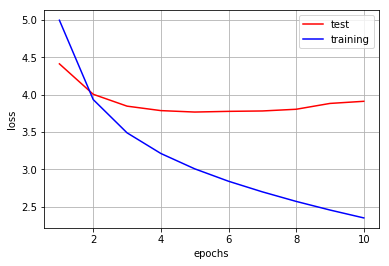

In [59]:
loss_train = seq2seq.history.history['loss']
loss_test = seq2seq.history.history['val_loss']
epochs = seq2seq.history.params['epochs']
epochs = range(1, epochs+1)

plt.plot(epochs, loss_test, 'r', label='test')
plt.plot(epochs, loss_train, 'b', label='training')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig("model_loss.png", dpi=200)
plt.show()

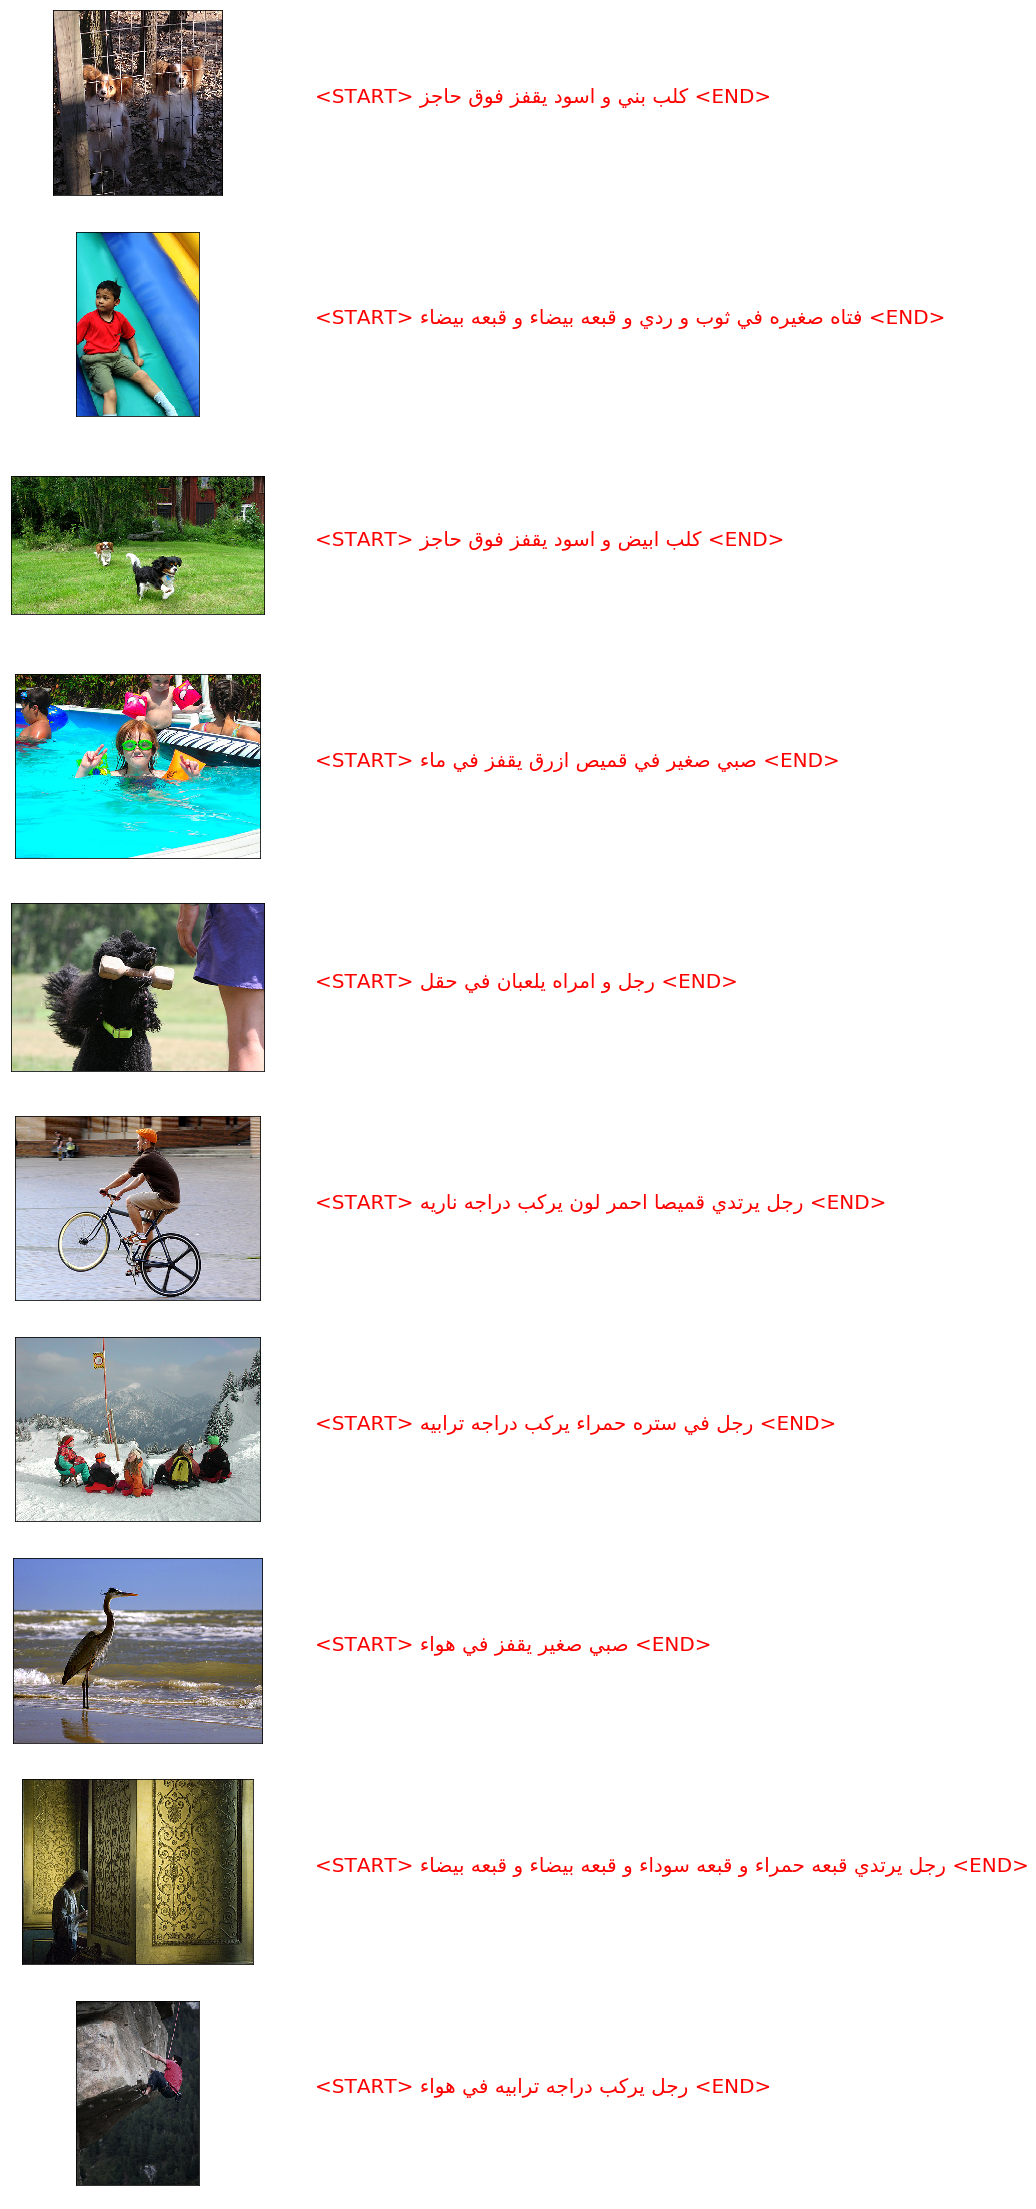

In [26]:
subset = {k:captions[k] for k in list(captions.keys())[-10:]}
pred = {}
for k,v in subset.items():
    cpt = predict_caption(seq2seq, features[k], tokenizer, max_len)
    pred[k] = [cpt]
visualize_images_with_captions(pred)

#good = [9, 10, 15, 18]
#bad = [21, 22, 29]

In [24]:
def chop_start_end(cpt):
    if cpt.startswith('<START>') and cpt.endswith('<END>'):
        cpt = ' '.join(cpt.split()[1:-1])
    return cpt

def get_one_by_three(X,Y):
    XX,YY=[],[]
    for i,(x,y) in enumerate(zip(X,Y)):
        if i%3 == 0:
            XX.append(x)
            temp_y = [y]
        else:
            temp_y.append(y)
            if i%3 == 2:
                YY.append(temp_y)
    return XX,YY

"""
def generate_captions(model, X, y):
    references, hypothesis = [],[]
    d = []  # [{'actual_caption':list(str), 'predicted_captions':str}]
    XX,YY = get_one_by_three(X_train, y_train)
    for xx,yy in zip(XX,YY):
        ref = tokenizer.sequences_to_texts(yy)
        pred = predict_caption(model, xx, tokenizer, max_len)
        d.append({'actual_caption':ref, 'predicted_caption':pred})
    return d
"""

def generate_captions(model, image_features):
    n_images = image_features.shape[0]
    generated_captions = ['<START>'] * n_images
    for word in range(max_len):
        seq = tokenizer.texts_to_sequences(generated_captions)
        seq = keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_len)
        seq = np.squeeze(np.array(seq))
        predictions = model.predict([image_features, seq], verbose=0)
        predictions = np.argmax(predictions, axis=1)
        for i,pred in enumerate(predictions):
            if generated_captions[i].endswith('<END>'): continue
            new_word = index2word[pred]
            generated_captions[i] += ' ' + new_word
    return generated_captions

def BLEU_corpus(actual_captions, generated_captions):
    list_of_references = []
    for images_captions in actual_captions:
        list_of_references.append([chop_start_end(cpt).split() for cpt in images_captions])
    hypotheses = [chop_start_end(cpt).split() for cpt in generated_captions]
    b1 = corpus_bleu(list_of_references, hypotheses, weights=(1, 0, 0, 0))
    b2 = corpus_bleu(list_of_references, hypotheses, weights=(0.5, 0.5, 0, 0))
    b3 = corpus_bleu(list_of_references, hypotheses, weights=(0.333, 0.333, 0.333, 0))
    b4 = corpus_bleu(list_of_references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
    return b1, b2, b3, b4

def BLEU_score(model, X, y):
    XX,YY = get_one_by_three(X_train, y_train)
    b1,b2,b3,b4 = [],[],[],[]
    for xx,yy in zip(XX,YY):
        ref = [tokenizer.sequences_to_texts([y_])[0] for y_ in yy]
        ref = [w for r in ref for w in chop_start_end(r).split()]
        ref = [list(set(ref))]
        pred = predict_caption(model, xx, tokenizer, max_len)
        pred = chop_start_end(pred).split()
        b1.append(sentence_bleu(ref, pred, weights=(1, 0, 0, 0)))
        b2.append(sentence_bleu(ref, pred, weights=(0.5, 0.5, 0, 0)))
        b3.append(sentence_bleu(ref, pred, weights=(1/3, 1/3, 1/3, 0)))
        b4.append(sentence_bleu(ref, pred, weights=(0.25, 0.25, 0.25, 0.25)))
    return np.mean(b1), np.mean(b2), np.mean(b3), np.mean(b4)

def plot_bleu_bar_graph(bleu_train, bleu_test):
    n_groups = 4
    #bleu_train = (b1_train,b2_train,b3_train,b4_train)
    #bleu_test = (b1_test,b2_test,b3_test,b4_test)
    # create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.3
    opacity = 0.8

    rects1 = plt.bar(index, bleu_train, bar_width,
                     alpha=opacity,
                     color='b',
                     label='train',
                     zorder=3)

    rects2 = plt.bar(index + bar_width, bleu_test, bar_width,
                     alpha=opacity,
                     color='r',
                     label='test',
                     zorder=3)

    plt.xlabel('BLEU')
    plt.ylabel('score')
    #plt.title('Scores')
    plt.xticks(index + bar_width, ('1', '2', '3', '4'))
    plt.legend()
    plt.tight_layout()
    plt.grid(True, axis='y')
    plt.savefig("BLEU_bar.png", dpi=200)
    plt.show()

In [34]:
%%time
XX_train, yy_train = get_one_by_three(X_train, y_train)
XX_train = np.squeeze(np.array(XX_train))
yy_train_text = [tokenizer.sequences_to_texts(y_) for y_ in yy_train]

generated_captions_train = generate_captions(seq2seq, XX_train)

XX_test, yy_test = get_one_by_three(X_test, y_test)
XX_test = np.squeeze(np.array(XX_test))
yy_test_text = [tokenizer.sequences_to_texts(y_) for y_ in yy_test]

generated_captions_test = generate_captions(seq2seq, XX_test)

Wall time: 48 s


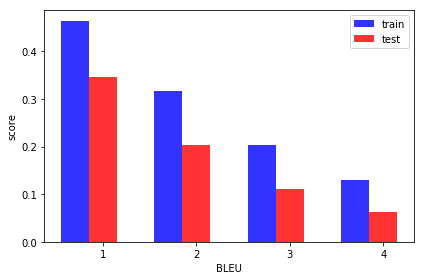

In [35]:
b1_train,b2_train,b3_train,b4_train = BLEU_corpus(yy_train_text, generated_captions_train)
b1_test,b2_test,b3_test,b4_test = BLEU_corpus(yy_test_text, generated_captions_test)

plot_bleu_bar_graph((b1_train,b2_train,b3_train,b4_train), (b1_test,b2_test,b3_test,b4_test))

### Merge Model

In [70]:
embeddings_dim = 256
input_image_dim = X_train_image.shape[1]

# feature extractor model
inputs1 = keras.layers.Input(shape=(input_image_dim,))
fe1 = keras.layers.Dropout(0.3)(inputs1)
fe2 = keras.layers.Dense(embeddings_dim, activation='relu')(fe1)
# sequence model
inputs2 = keras.layers.Input(shape=(max_len,))
se1 = keras.layers.Embedding(len(word2index), embeddings_dim, mask_zero=True)(inputs2)
se2 = keras.layers.Dropout(0.3)(se1)
se3 = keras.layers.LSTM(embeddings_dim)(se2)
# decoder model
decoder1 = keras.layers.merge.add([fe2, se3])
decoder2 = keras.layers.Dense(embeddings_dim, activation='relu')(decoder1)
outputs = keras.layers.Dense(len(word2index), activation='softmax')(decoder2)
# tie it together [image, seq] [word]
merge_model = keras.Model(inputs=[inputs1, inputs2], outputs=outputs)
# compile model
merge_model.compile(loss='categorical_crossentropy', optimizer='adam')
# summarize model
merge_model.summary()
#plot_model(model, to_file='others/merge_model.png', show_shapes=True)

merge_model.fit([X_train_image, X_train_text], y_train_text,
          validation_data=([X_test_image, X_test_text], y_test_text),
          batch_size=1024,
          epochs=10,
          verbose=2,
          callbacks=[TQDMNotebookCallback()])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 26, 256)      2671360     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

Epoch 1/10


 - 27s - loss: 5.7272 - val_loss: 5.1625
Epoch 2/10


 - 24s - loss: 4.4667 - val_loss: 4.6974
Epoch 3/10


 - 24s - loss: 3.8369 - val_loss: 4.5452
Epoch 4/10


 - 24s - loss: 3.3722 - val_loss: 4.5109
Epoch 5/10


 - 24s - loss: 3.0109 - val_loss: 4.5543
Epoch 6/10


 - 24s - loss: 2.7310 - val_loss: 4.5978
Epoch 7/10


 - 24s - loss: 2.5173 - val_loss: 4.6545
Epoch 8/10


 - 24s - loss: 2.3523 - val_loss: 4.6939
Epoch 9/10


 - 24s - loss: 2.2126 - val_loss: 4.7459
Epoch 10/10


 - 24s - loss: 2.0975 - val_loss: 4.7948



In [45]:
b1_train,b2_train,b3_train,b4_train = BLEU_score(merge_model, X_train, y_train)
b1_test,b2_test,b3_test,b4_test = BLEU_score(merge_model, X_test, y_test)

c:\python\python36\coding4fun\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\python\python36\coding4fun\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\python\python36\coding4fun\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunc

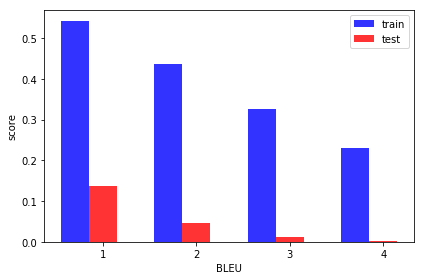

In [46]:
plot_bleu_bar_graph((b1_train,b2_train,b3_train,b4_train), (b1_test,b2_test,b3_test,b4_test))

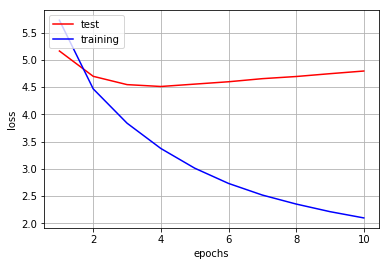

In [71]:
loss_train = merge_model.history.history['loss']
loss_test = merge_model.history.history['val_loss']
epochs = merge_model.history.params['epochs']
epochs = range(1, epochs+1)

plt.plot(epochs, loss_test, 'r', label='test')
plt.plot(epochs, loss_train, 'b', label='training')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

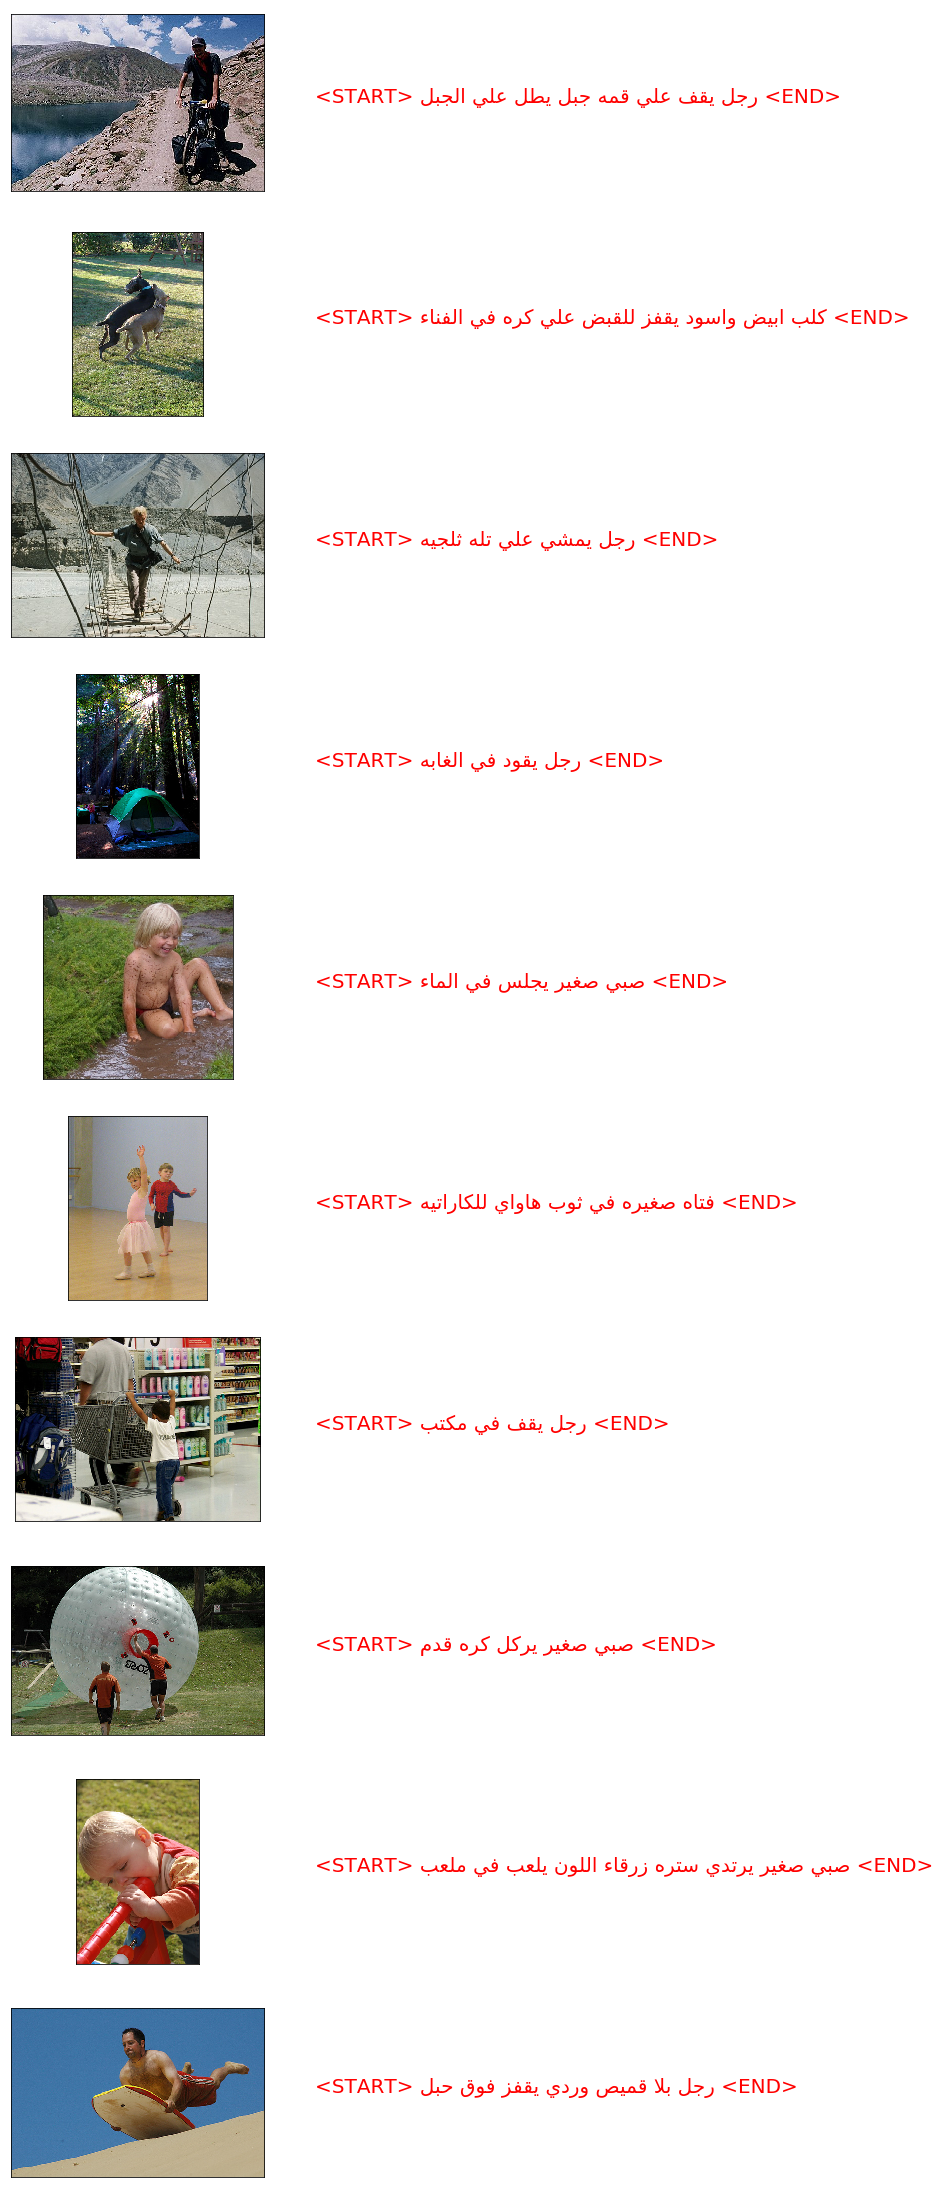

In [74]:
subset = {k:captions[k] for k in list(captions.keys())[-40:-30]}
pred = {}
for k,v in subset.items():
    cpt = predict_caption(merge_model, features[k], tokenizer, max_len)
    pred[k] = [cpt]
visualize_images_with_captions(pred)

#good = [9, 10, 15, 18]
#bad = [21, 22, 29]

### load model & evaluate

In [56]:
%%time
from keras.models import load_model

pretrained_model = load_model('models/model.10-3.912--0.332.hdf5')
#pretrained_model = seq2seq

XX_train, yy_train = get_one_by_three(X_train, y_train)
XX_train = np.squeeze(np.array(XX_train))
yy_train_text = [tokenizer.sequences_to_texts(y_) for y_ in yy_train]
generated_captions_train = generate_captions(pretrained_model, XX_train)

XX_test, yy_test = get_one_by_three(X_test, y_test)
XX_test = np.squeeze(np.array(XX_test))
yy_test_text = [tokenizer.sequences_to_texts(y_) for y_ in yy_test]
generated_captions_test = generate_captions(pretrained_model, XX_test)

Wall time: 58.8 s


{'testlen': 51467, 'reflen': 50165, 'guess': [51467, 44176, 36885, 29598], 'correct': [27876, 12883, 5518, 2230]}
ratio: 1.0259543506428581
{'testlen': 5969, 'reflen': 5658, 'guess': [5969, 5169, 4369, 3570], 'correct': [1981, 578, 136, 33]}
ratio: 1.0549664192292232


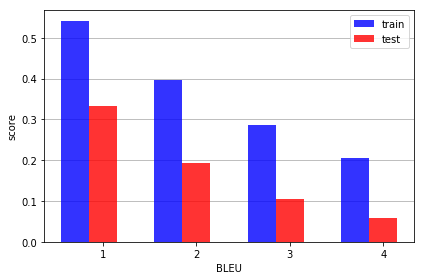

In [57]:
def get_bleu_score(actual_captions, generated_captiones):
    list_of_references = []
    for images_captions in actual_captions:
        list_of_references.append([chop_start_end(cpt) for cpt in images_captions])
    hypotheses = [chop_start_end(cpt) for cpt in generated_captiones]
    refs, hyps = {}, {}
    for i,(actual, pred) in enumerate(zip(list_of_references,hypotheses)):
        refs['id{}'.format(i)] = actual
        hyps['id{}'.format(i)] = [pred]
    b = Bleu(n=4)
    return b.compute_score(refs, hyps)[0]

b1_train,b2_train,b3_train,b4_train = get_bleu_score(yy_train_text, generated_captions_train)
b1_test,b2_test,b3_test,b4_test = get_bleu_score(yy_test_text, generated_captions_test)
plot_bleu_bar_graph((b1_train,b2_train,b3_train,b4_train), (b1_test,b2_test,b3_test,b4_test))

In [58]:
print(b1_test,b2_test,b3_test,b4_test)

0.331881387166974 0.19264249814563814 0.10492694351151749 0.05716453795768872


### compare with translated captions

In [63]:
translated_captions = []
translated_english_generated_captions_file = 'resources/translation_of_english_generated_captions.txt'
with open(translated_english_generated_captions_file, 'r', encoding='utf-8') as file:
    for line in file.readlines():
        #separate image names & english captions
        img, cpt = line.split('\t')
        #append translated caption
        translated_captions.append(cpt)
print('DONE :)')

DONE :)


In [73]:
process_arab = Arabic_preprocessing()
processed_translated_captions = [process_arab.preprocess_arabic_text(c) for c in translated_captions]

In [78]:
b1_testt,b2_testt,b3_testt,b4_testt = get_bleu_score(yy_test_text, processed_translated_captions)
print(b1_testt,b2_testt,b3_testt,b4_testt)

{'testlen': 5464, 'reflen': 5564, 'guess': [5464, 4664, 3864, 3064], 'correct': [1474, 241, 26, 5]}
ratio: 0.98202731847574
0.26487349640166147 0.11592426696704082 0.04461136921414441 0.019420812858244055


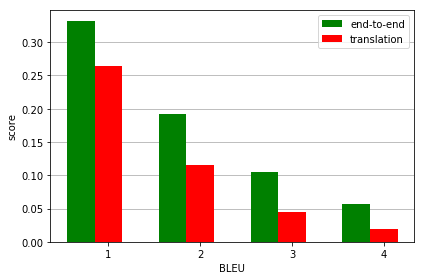

In [80]:
n_groups = 4
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index, (b1_test,b2_test,b3_test,b4_test), bar_width,
                 alpha=1,
                 color='g',
                 label='end-to-end',
                 zorder=5)

rects2 = plt.bar(index + bar_width, (b1_testt,b2_testt,b3_testt,b4_testt), bar_width,
                 alpha=1,
                 color='r',
                 label='translation',
                 zorder=5)

plt.xlabel('BLEU')
plt.ylabel('score')
plt.xticks(index + bar_width, ('1', '2', '3', '4'))
plt.legend()
plt.tight_layout()
plt.grid(True, axis='y')
plt.savefig("BLEU_bar.png", dpi=200)
plt.show()